# COMP 247 Project - Group 5
Predition of Killed or Seriously Injured (KSI) in Traffic Accidents in Toronto Dataset
<hr>
Aazain Ullah Khan, Younghun Mun, Tuong Nguyen Pham, Reet Kaur, Dongheun Yang
<hr>


In [238]:
# Import libraries
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [239]:
# Load the dataset
df = pd.read_csv('KSI.csv')

In [240]:
# Print the shape of the data
print(df.shape)

(18194, 57)


In [241]:
# Print the first 5 rows of the data
print(df.head())

              X             Y   INDEX_    ACCNUM  YEAR  \
0 -8.844611e+06  5.412414e+06  3387730  892658.0  2006   
1 -8.844611e+06  5.412414e+06  3387731  892658.0  2006   
2 -8.816480e+06  5.434843e+06  3388101  892810.0  2006   
3 -8.829728e+06  5.419071e+06  3389067  893184.0  2006   
4 -8.816480e+06  5.434843e+06  3388102  892810.0  2006   

                     DATE  TIME          STREET1         STREET2 OFFSET  ...  \
0  2006/03/11 05:00:00+00   852       BLOOR ST W     DUNDAS ST W    NaN  ...   
1  2006/03/11 05:00:00+00   852       BLOOR ST W     DUNDAS ST W    NaN  ...   
2  2006/03/11 05:00:00+00   915  MORNINGSIDE AVE  SHEPPARD AVE E    NaN  ...   
3  2006/01/01 05:00:00+00   236     WOODBINE AVE     O CONNOR DR    NaN  ...   
4  2006/03/11 05:00:00+00   915  MORNINGSIDE AVE  SHEPPARD AVE E    NaN  ...   

  AG_DRIV REDLIGHT  ALCOHOL  DISABILITY  HOOD_158 NEIGHBOURHOOD_158 HOOD_140  \
0     Yes      NaN      NaN         NaN        88   High Park North       88   
1     Yes 

In [242]:
# Print the info of the data
df.info()

# Print the summary statistics of the data
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18194 entries, 0 to 18193
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  18194 non-null  float64
 1   Y                  18194 non-null  float64
 2   INDEX_             18194 non-null  int64  
 3   ACCNUM             13264 non-null  float64
 4   YEAR               18194 non-null  int64  
 5   DATE               18194 non-null  object 
 6   TIME               18194 non-null  int64  
 7   STREET1            18194 non-null  object 
 8   STREET2            16510 non-null  object 
 9   OFFSET             3402 non-null   object 
 10  ROAD_CLASS         17818 non-null  object 
 11  DISTRICT           18089 non-null  object 
 12  WARDNUM            17332 non-null  float64
 13  LATITUDE           18194 non-null  float64
 14  LONGITUDE          18194 non-null  float64
 15  LOCCOORD           18099 non-null  object 
 16  ACCLOC             127

In [243]:
# Check for missing values
print(df.isnull().sum())

X                        0
Y                        0
INDEX_                   0
ACCNUM                4930
YEAR                     0
DATE                     0
TIME                     0
STREET1                  0
STREET2               1684
OFFSET               14792
ROAD_CLASS             376
DISTRICT               105
WARDNUM                862
LATITUDE                 0
LONGITUDE                0
LOCCOORD                95
ACCLOC                5450
TRAFFCTL                34
VISIBILITY              20
LIGHT                    0
RDSFCOND                25
ACCLASS                  5
IMPACTYPE                4
INVTYPE                 16
INVAGE                   0
INJURY                1611
FATAL_NO             17367
INITDIR               5052
VEHTYPE               3228
MANOEUVER             7660
DRIVACT               8951
DRIVCOND              8954
PEDTYPE              15134
PEDACT               15112
PEDCOND              15110
CYCLISTYPE           17420
CYCACT               17428
C

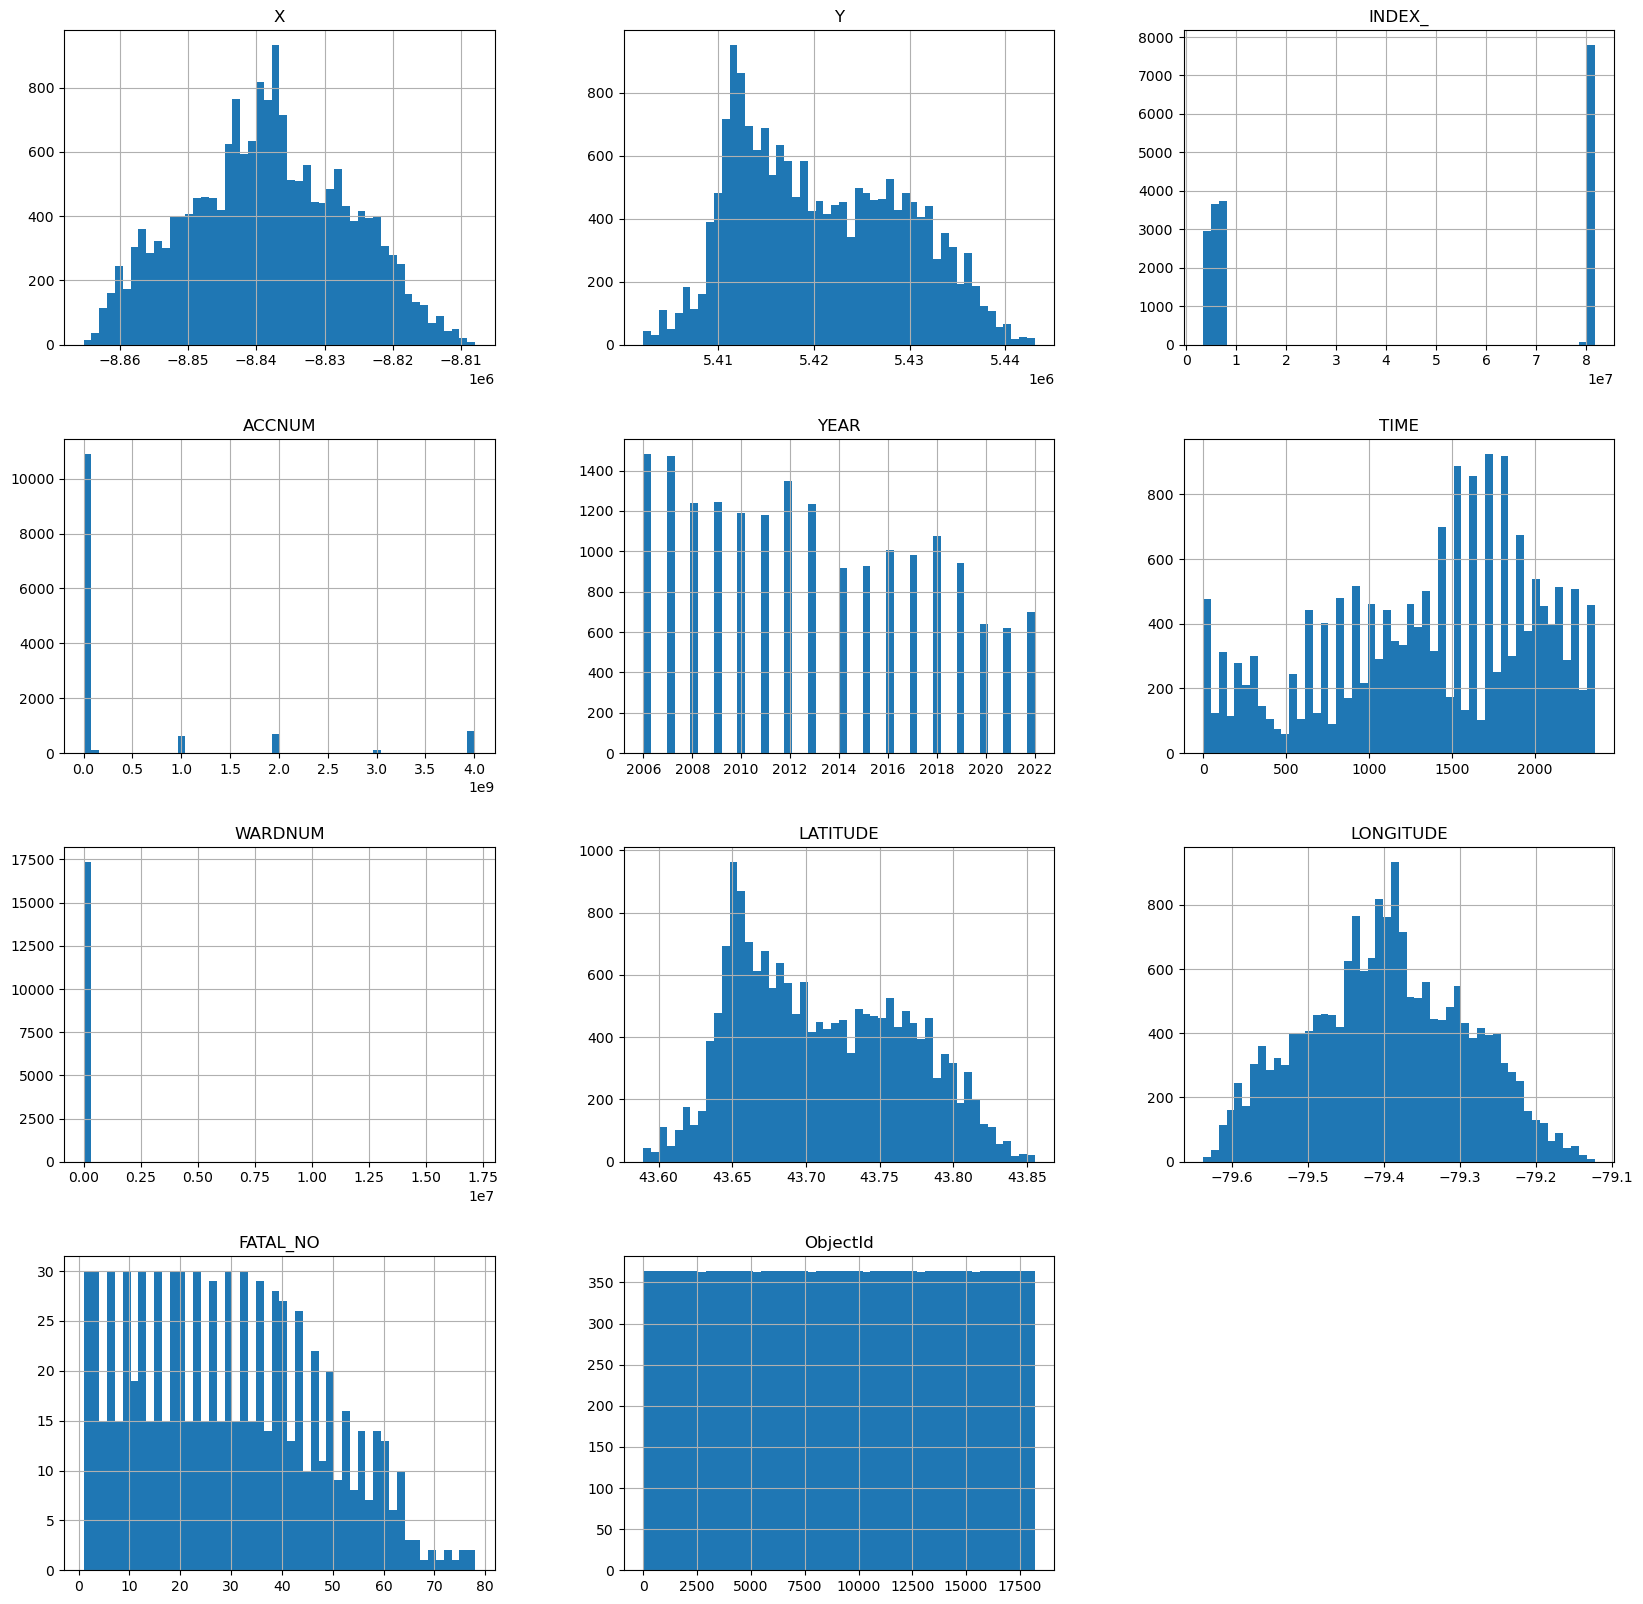

In [244]:
# Plot histogram
df.hist(bins=50, figsize=(20, 20))
plt.show()

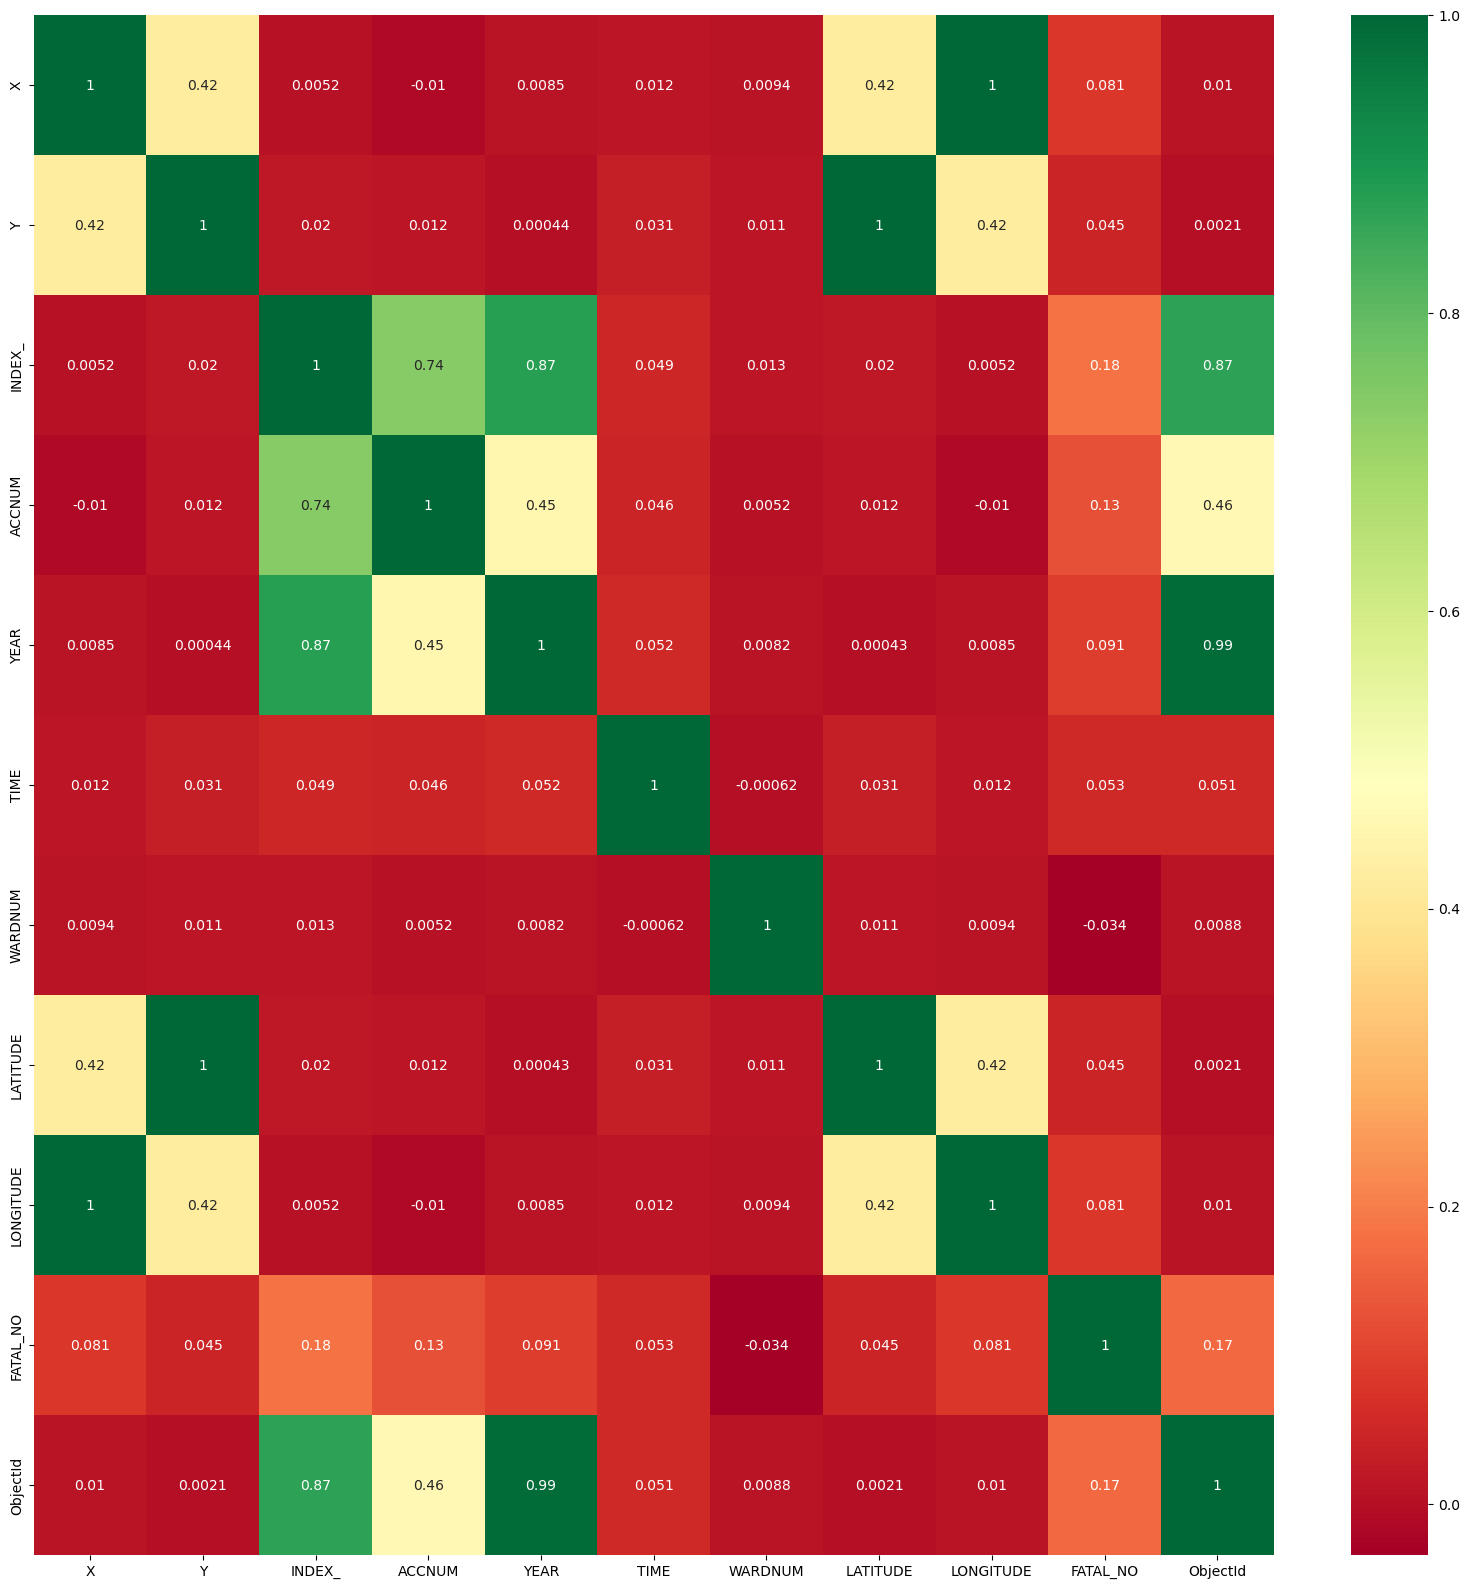

In [245]:
# Plot correlation matrix of numerical columns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdYlGn')
plt.show()

In [246]:
# * From correlation matrix, we can see that 'X' and 'LONGITUDE', 'Y' and 'LATITUDE' are highly correlated. So, we can drop one of them.
columns_to_drop = ['X', 'Y']
df = df.drop(columns=columns_to_drop)
# Get the columns which are boolean

bool_cols = [df.columns[col] for col in range(36, 49)]

In [247]:
# Fill missing values with 'No' in boolean columns
bool_attributes = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH',
                   'EMERG_VEH', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']

for attribute in bool_attributes:
    df[attribute] = df[attribute].map(
        {'Yes': 1, '': 0}).fillna(0).astype(int)

# Drop columns having more than 80% missing values
missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_drop = missing_percentages[missing_percentages > 80].index
df = df.drop(columns=columns_to_drop)

# Drop columns which may not be useful for analysis
columns_to_drop = ['ObjectId', 'INDEX_', 'ACCNUM', 'STREET1', 'STREET2',
                   'DISTRICT', 'WARDNUM', 'DIVISION', 'NEIGHBOURHOOD_158', 'NEIGHBOURHOOD_140']
'''
Explanation:
ObjectId, INDEX_, ACCNUM: These columns are unique for each row
NEIGHBOURHOOD_158, NEIGHBOURHOOD_140: These columns are indentical to 'HOOD_158' and 'HOOD_140' respectively
STREET1, STREET2: According to the requirement, model will predict the severity of accident in certain neighbourhoods
'''

"\nExplanation:\nObjectId, INDEX_, ACCNUM: These columns are unique for each row\nNEIGHBOURHOOD_158, NEIGHBOURHOOD_140: These columns are indentical to 'HOOD_158' and 'HOOD_140' respectively\nSTREET1, STREET2: According to the requirement, model will predict the severity of accident in certain neighbourhoods\n"

In [248]:
#! 'INJURY' feature which might be dropped depends on the accuracy score of model
df = df.drop(columns=columns_to_drop)

# Convert 'property' to 'non fatal'
df['ACCLASS'] = df['ACCLASS'].str.replace(
    "Property Damage Only", "Non-Fatal Injury")

# Categorical columns which have <3% missing values, we can drop them. The number is not remarkable, it won't affect the accuracy, it is just below 3%
cat_cols = df.select_dtypes(include='object')  # get only categorical columns
missing_percentages = cat_cols.isnull().sum()/len(df) * 100
cat_col_val_drop = missing_percentages[missing_percentages <= 3].index
cat_col_val_drop
df = df.dropna(subset=cat_col_val_drop)


print(df.isnull().sum())

YEAR                 0
DATE                 0
TIME                 0
ROAD_CLASS           0
LATITUDE             0
LONGITUDE            0
LOCCOORD             0
ACCLOC            5080
TRAFFCTL             0
VISIBILITY           0
LIGHT                0
RDSFCOND             0
ACCLASS              0
IMPACTYPE            0
INVTYPE              0
INVAGE               0
INJURY            1545
INITDIR           4805
VEHTYPE           3173
MANOEUVER         7469
DRIVACT           8656
DRIVCOND          8658
PEDESTRIAN           0
CYCLIST              0
AUTOMOBILE           0
MOTORCYCLE           0
TRUCK                0
TRSN_CITY_VEH        0
EMERG_VEH            0
PASSENGER        11041
SPEEDING             0
AG_DRIV              0
REDLIGHT             0
ALCOHOL              0
DISABILITY           0
HOOD_158             0
HOOD_140             0
dtype: int64


In [249]:
# Fill null values to naN
from datetime import datetime
df = df.fillna(value=np.nan)

def calculate_hour_and_minutes(time_val):
    # Ensure the time value is a string with leading zeros if necessary
    time_str = str(time_val).zfill(4)
    return int(time_str[:2]), int(time_str[2:])


df['DATE'] = pd.to_datetime(df['DATE'])

df[['HOUR', 'MINUTES']] = df['TIME'].apply(
    lambda x: calculate_hour_and_minutes(x)).apply(pd.Series)

df['MONTH'] = df['DATE'].dt.month_name()  # Get months
df['DAY'] = df['DATE'].dt.day  # Get days
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday + 1  # Get days of week
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].replace({1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})
df = df.drop(columns=['DATE'], axis=1)  # Drop 'DATE' column

['Friday' 'Saturday' 'Tuesday' 'Wednesday' 'Thursday' 'Monday' 'Sunday']


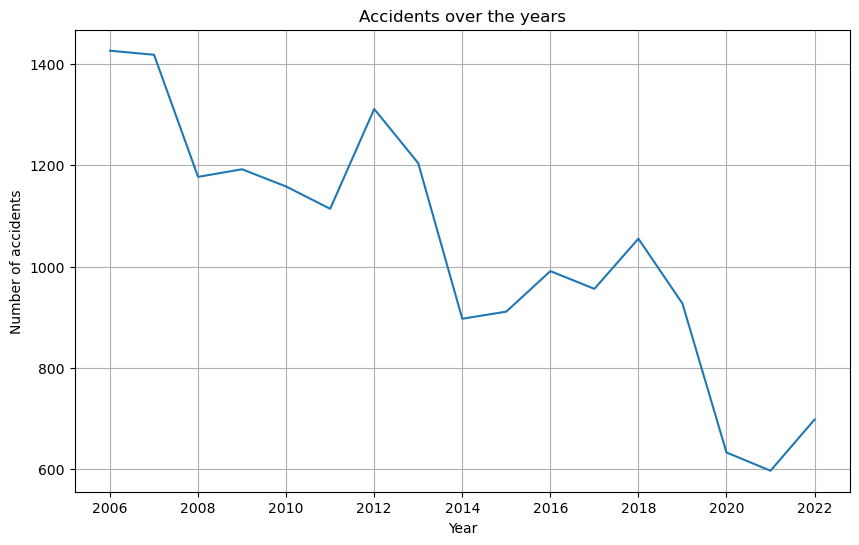

In [250]:
# accidents over the years green line plot to show the trend
plt.figure(figsize=(10, 6))
df['YEAR'].value_counts().sort_index().plot()
plt.title('Accidents over the years')
plt.xlabel('Year')
plt.ylabel('Number of accidents')
plt.grid()
plt.show()

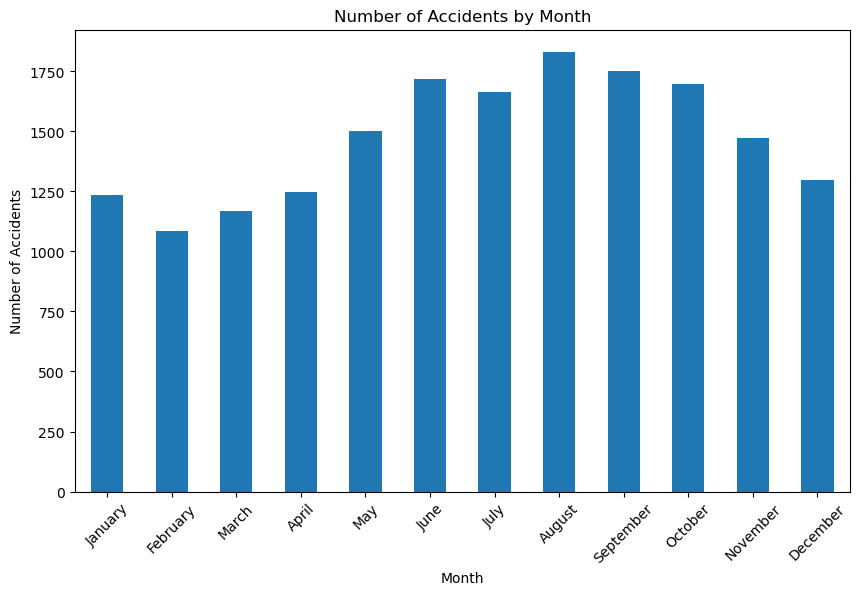

In [251]:
# Plot the number of accidents happened in each month
plt.figure(figsize=(25, 20))
df['MONTH'].value_counts().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                                    'October', 'November', 'December']).plot(kind='bar', figsize=(10, 6)).plot(kind='bar', figsize=(10, 6))
plt.title('Number of Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

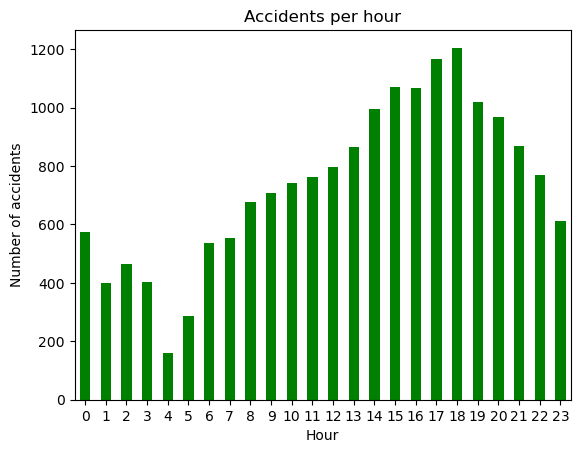

In [252]:
# accident by time of day
df['HOUR'].value_counts().sort_index().plot(kind='bar', color='green')
plt.xlabel('Hour')
plt.ylabel('Number of accidents')
plt.title('Accidents per hour')
plt.xticks(rotation=0)
plt.show()

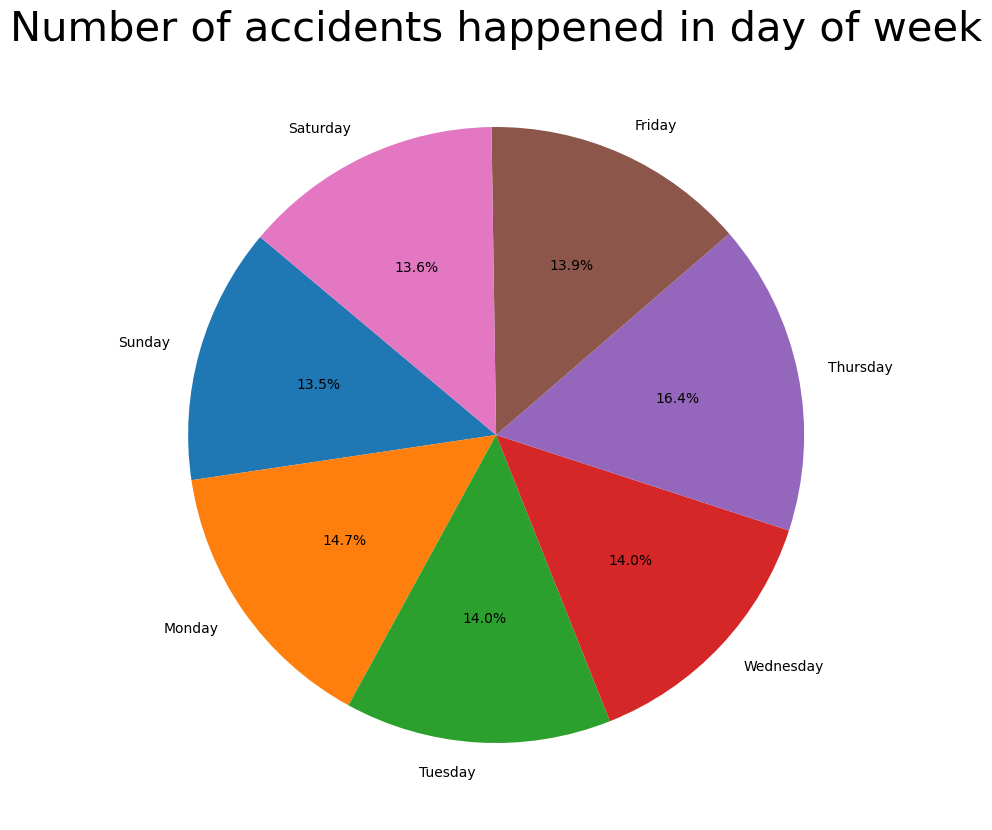

In [253]:
plt.figure(figsize=(10, 10))
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df['DAY_OF_WEEK'].value_counts().reindex(ordered_days).plot(
    kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Number of accidents happened in day of week', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('')
plt.show()

Text(0.5, 0, 'Total accidents by cause of accident')

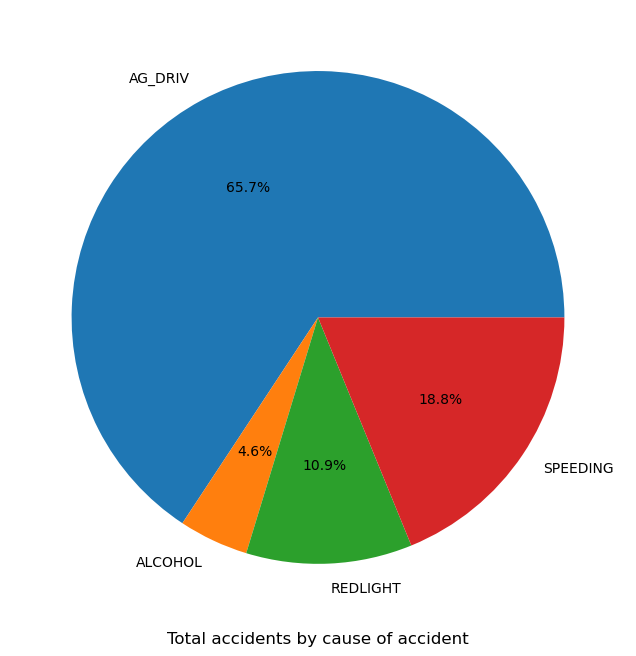

In [254]:
KSI_pivot_cause = df.pivot_table(index='YEAR',
                                 values=['SPEEDING', 'AG_DRIV',
                                         'REDLIGHT', 'ALCOHOL'],
                                 aggfunc=np.sum,
                                 margins=True,
                                 margins_name='Total Under Category')
fig, ax1 = plt.subplots(figsize=(8, 8))
KSI_pivot_cause.iloc[11].plot(
    kind='pie', ax=ax1, autopct='%3.1f%%', fontsize=10)
ax1.set_ylabel('')
ax1.set_xlabel('Total accidents by cause of accident', fontsize=12)

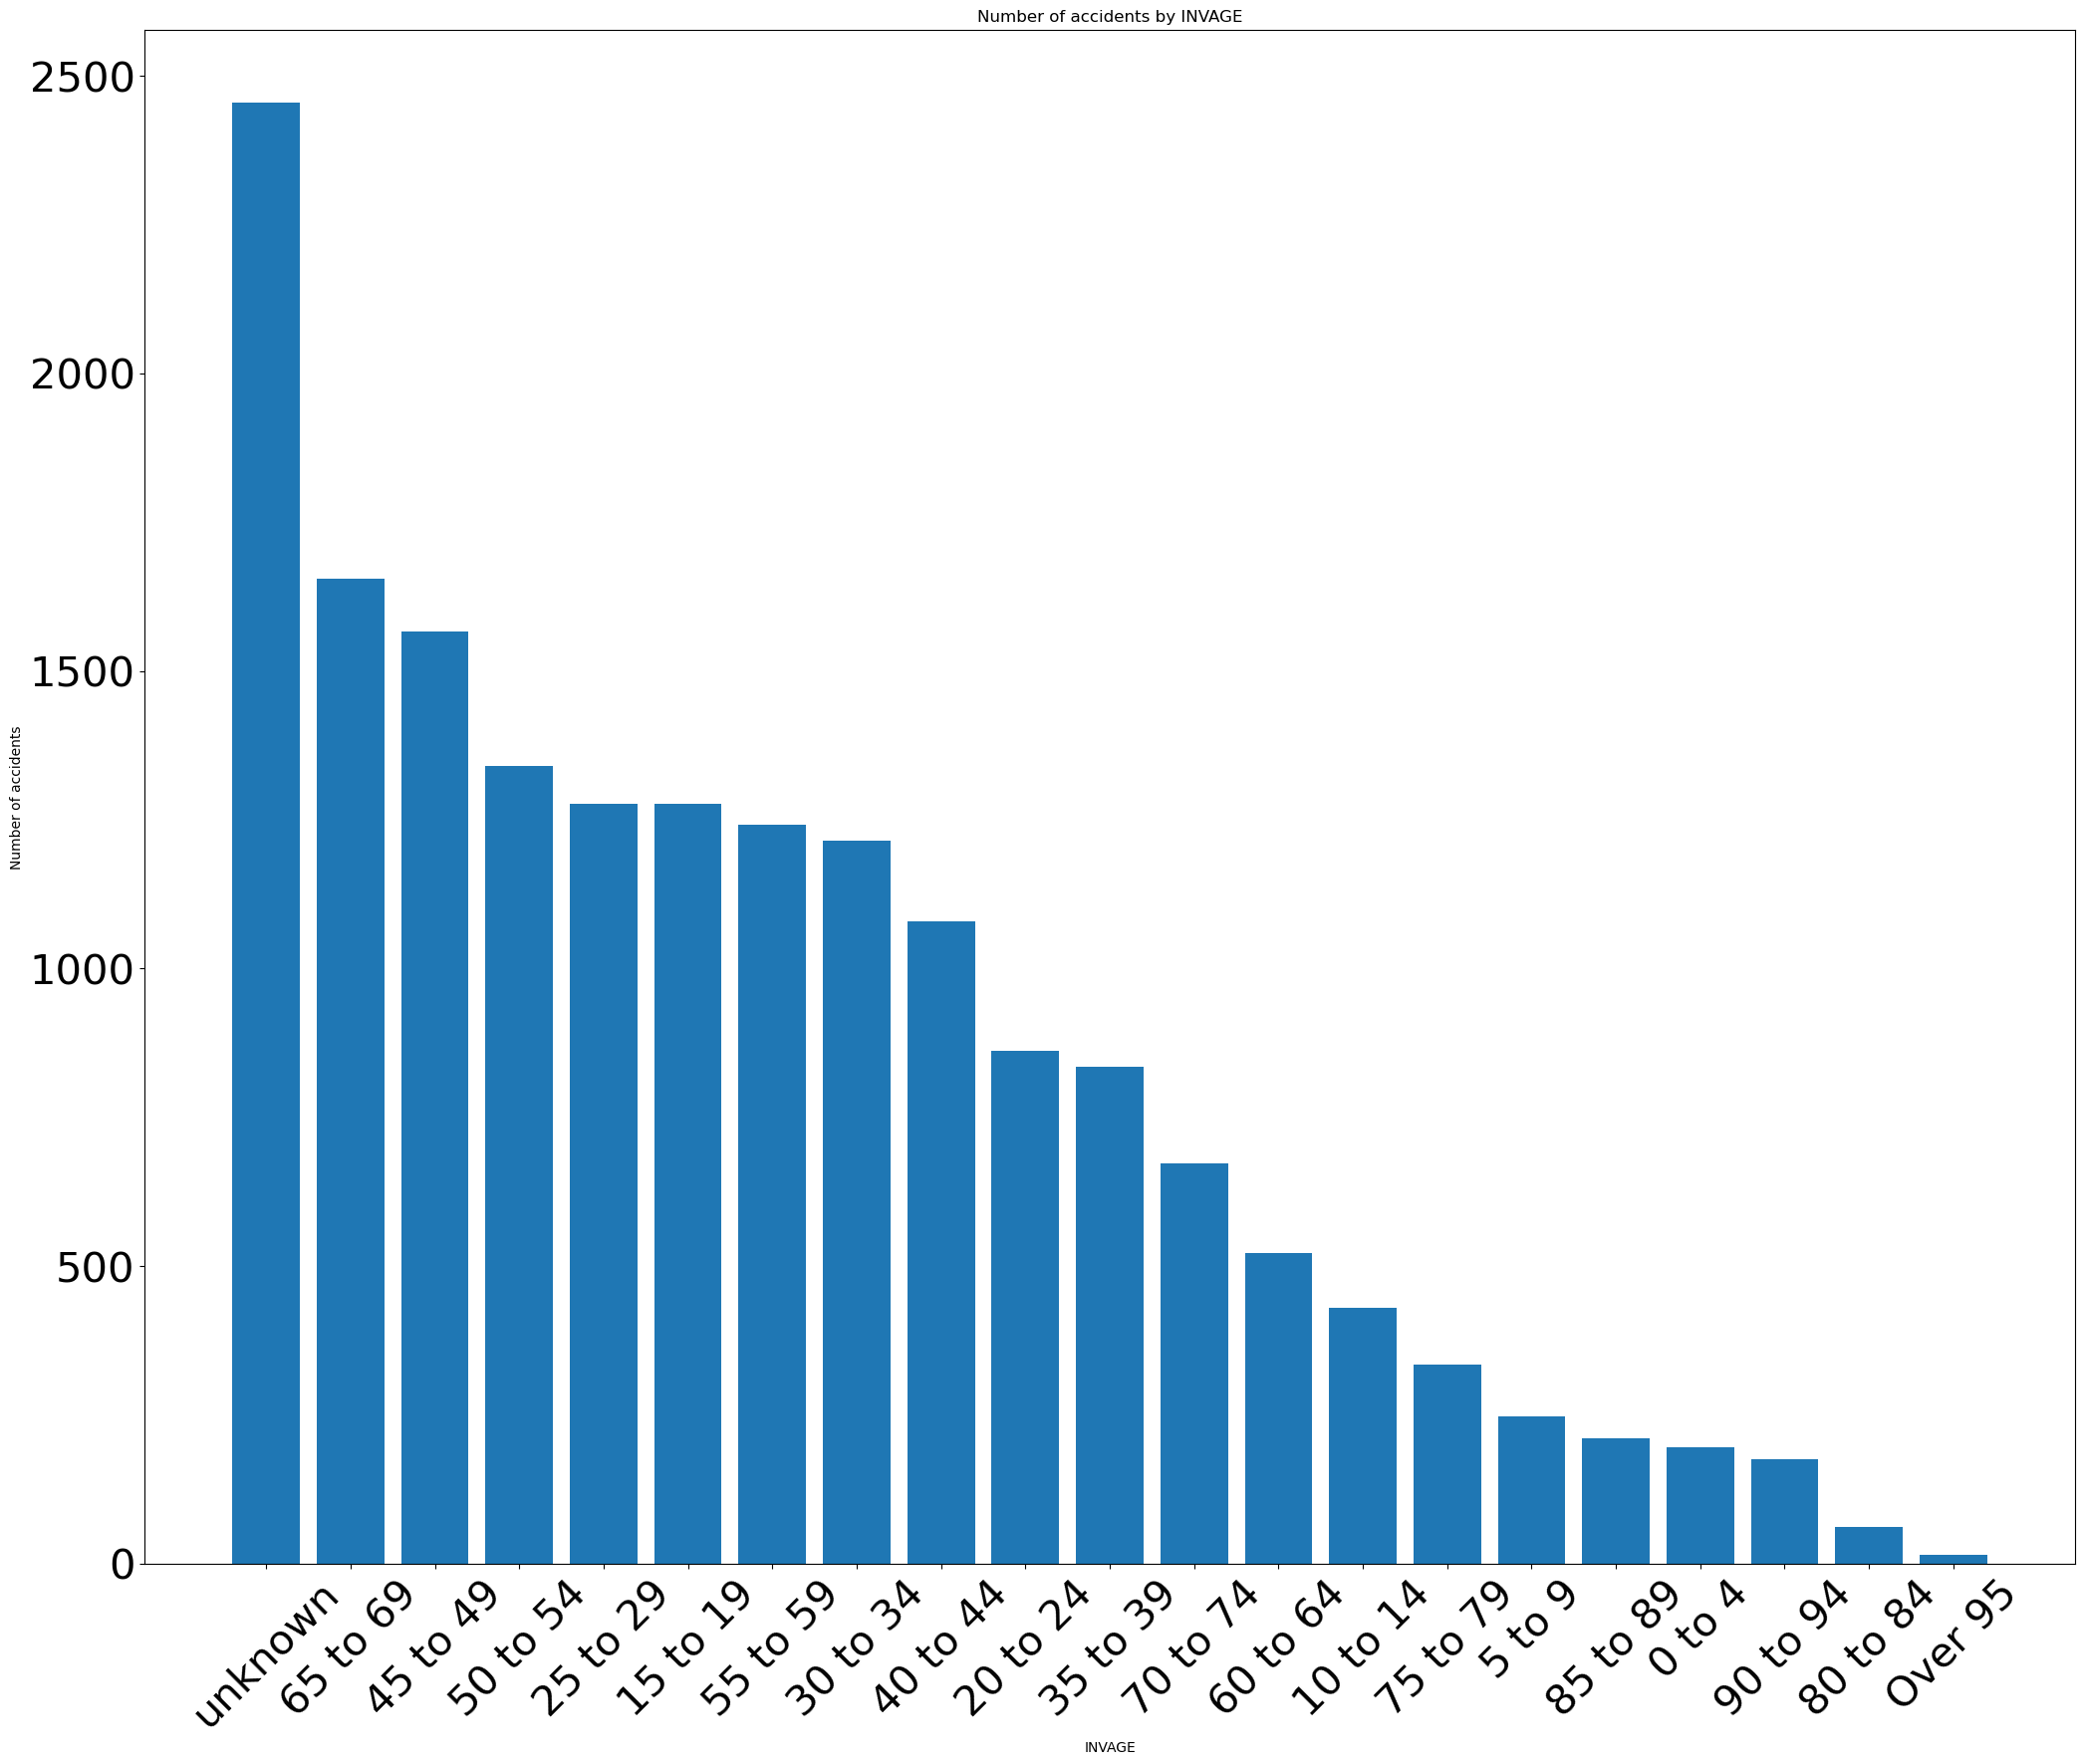

In [255]:
# Plot the number of accidents by INVAGE
plt.figure(figsize=(25, 20))
plt.bar(df['INVAGE'].unique(), df['INVAGE'].value_counts().values)
plt.title('Number of accidents by INVAGE')
plt.xlabel('INVAGE')
plt.ylabel('Number of accidents')
plt.xticks(fontsize=30, rotation=45)
plt.yticks(fontsize=30)
plt.show()

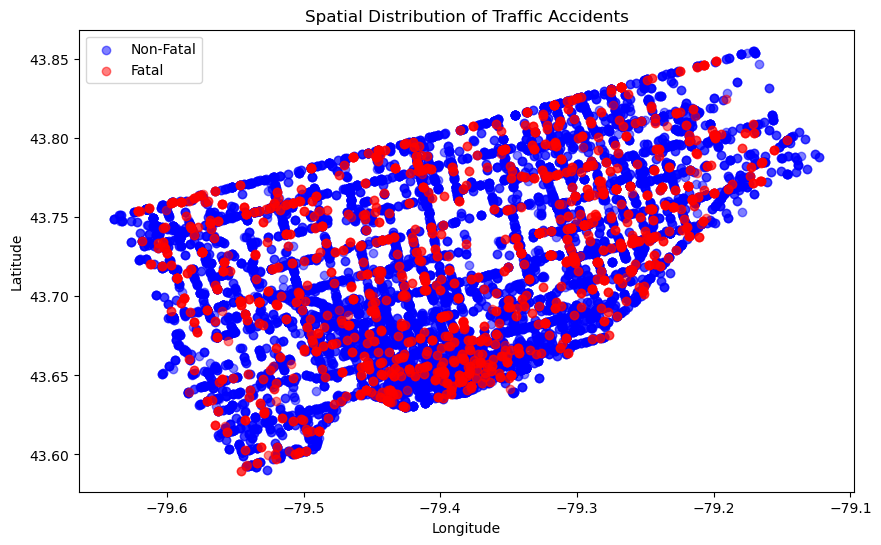

In [256]:
# Scatter plot of LATITUDE vs LONGITUDE
fatal_accidents = df[df['ACCLASS'] == 'Fatal']
non_fatal_accidents = df[df['ACCLASS'] != 'Fatal']
plt.figure(figsize=(10, 6))
# Plot non-fatal accidents
plt.scatter(non_fatal_accidents['LONGITUDE'], non_fatal_accidents['LATITUDE'],
            alpha=0.5, label='Non-Fatal', color='blue')
# Plot fatal accidents
plt.scatter(fatal_accidents['LONGITUDE'], fatal_accidents['LATITUDE'],
            alpha=0.5, label='Fatal', color='red')
plt.title('Spatial Distribution of Traffic Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [257]:
import folium
from folium.plugins import HeatMap

KSI_Fatal = df[df['ACCLASS'] == 'Fatal']
KSI_Fatal = KSI_Fatal[['LATITUDE', 'LONGITUDE', 'ACCLASS']]
lat_Toronto = df.describe().at['mean', 'LATITUDE']
lng_Toronto = df.describe().at['mean', 'LONGITUDE']
Toronto_location = [lat_Toronto, lng_Toronto]

KSI_Fatal_values = KSI_Fatal[['LATITUDE', 'LONGITUDE']].values.astype(float)

Fatal_map = folium.Map(Toronto_location, zoom_start=10.255)
HeatMap(KSI_Fatal_values, min_opacity=0.2).add_to(Fatal_map)
Fatal_map

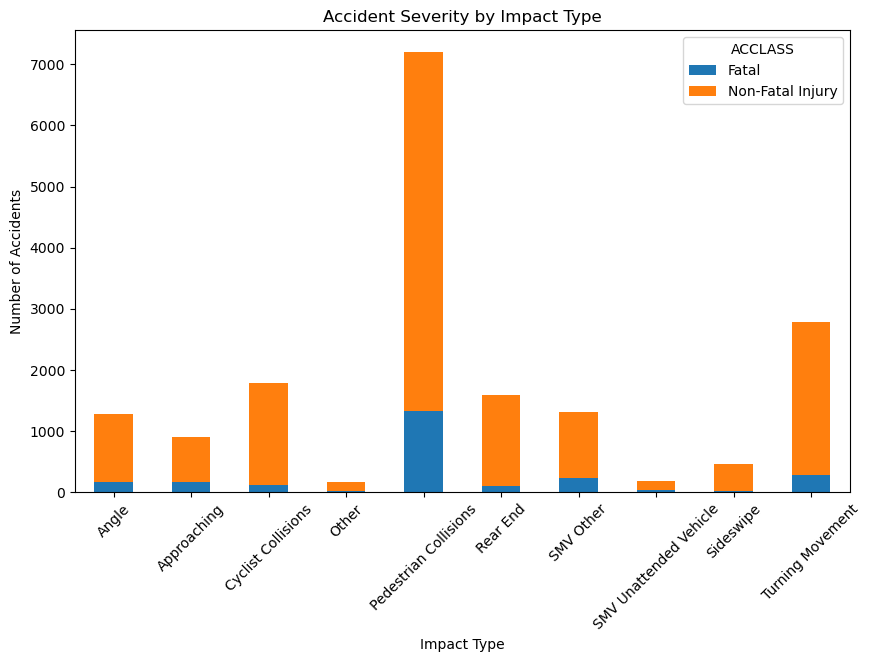

In [258]:

# Plot Accident Severity by Impact Type
df.groupby('IMPACTYPE')['ACCLASS'].value_counts().unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6))
plt.title('Accident Severity by Impact Type')
plt.xlabel('Impact Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

In [259]:

# Using chi-square test to find correlation between categorical columns and 'ACCLASS' column
cat_df = df.select_dtypes(include='object')
ordinal_encoder = OrdinalEncoder()
cat_df = ordinal_encoder.fit_transform(cat_df)
cat_df = pd.DataFrame(
    cat_df, columns=df.select_dtypes(include='object').columns)

In [260]:
X = cat_df.drop(columns=['ACCLASS'], axis=1)
feature_names = list(X.columns)
X = SimpleImputer(strategy='most_frequent').fit_transform(X)
y = cat_df['ACCLASS']
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(feature_names, columns=['Specs'])
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# Ascending order
featureScores = featureScores.sort_values(by='Score', ascending=False)

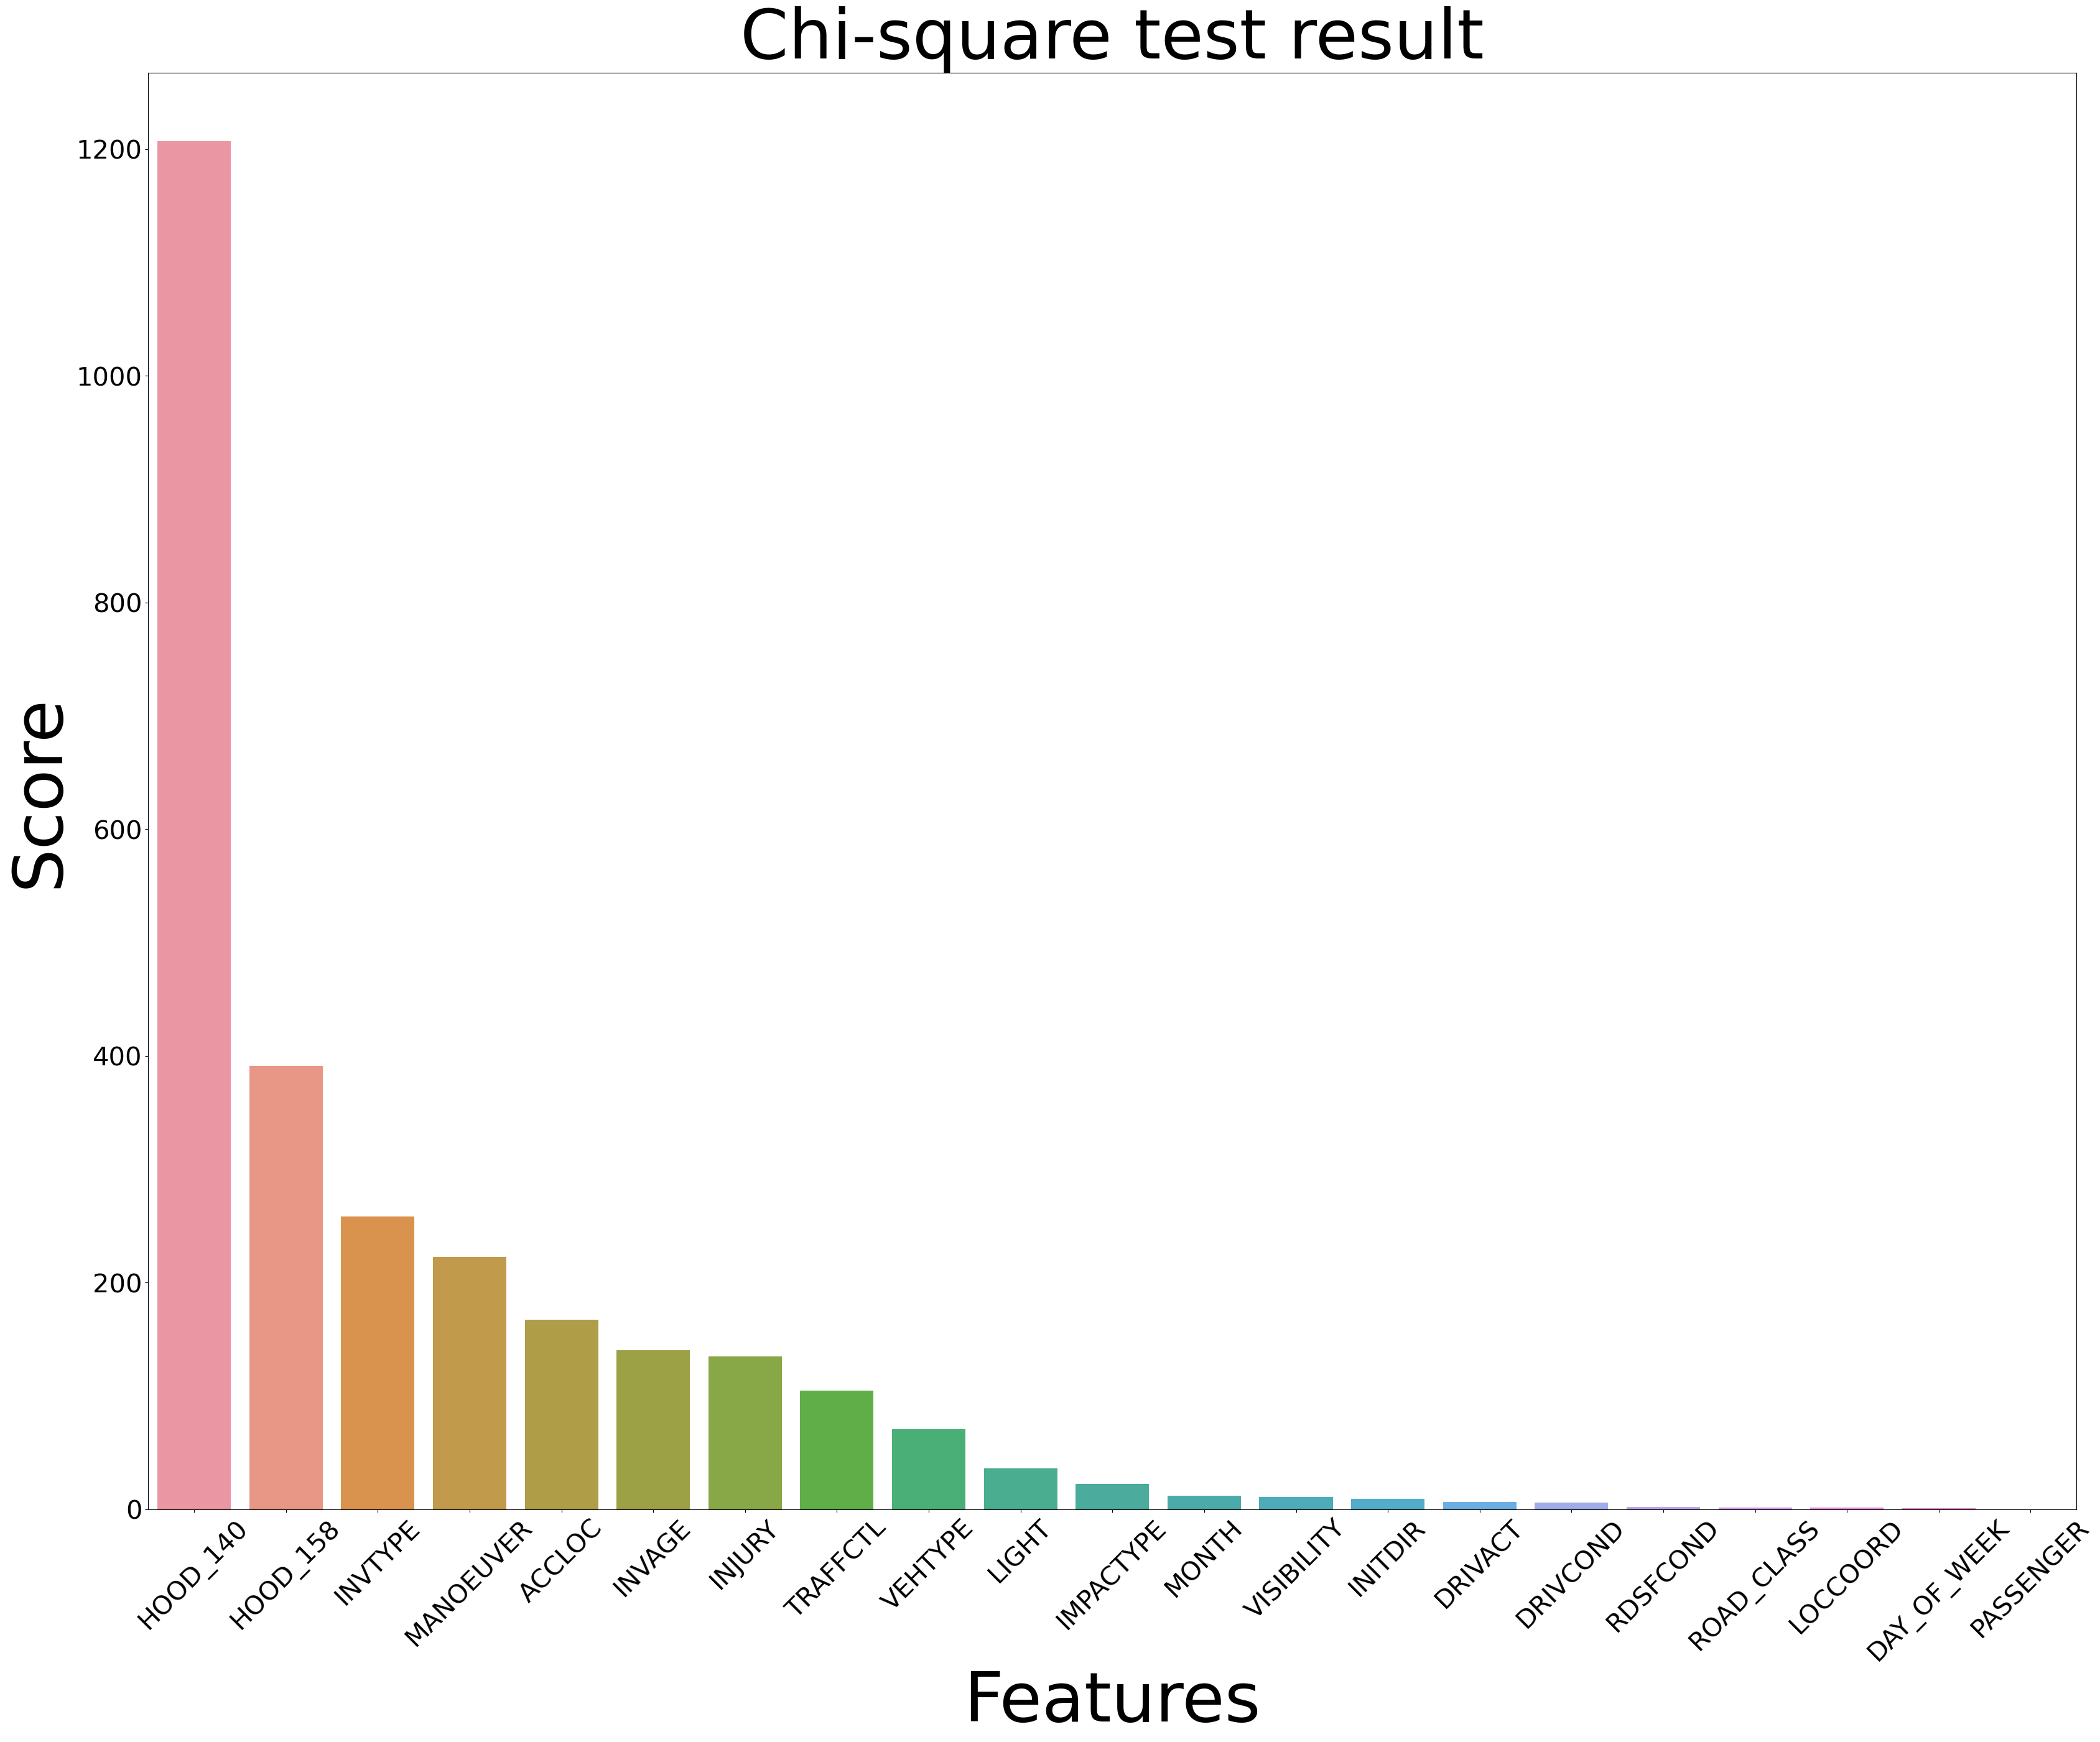

In [261]:
plt.figure(figsize=(40, 30))
sns.barplot(x='Specs', y='Score', data=featureScores)
plt.title('Chi-square test result', fontsize=80)
plt.xlabel('Features', fontsize=80)
plt.ylabel('Score', fontsize=80)
plt.xticks(fontsize=30, rotation=45)
plt.yticks(fontsize=30)
plt.show()

In [262]:
# Create new variable to use RFE
# Using model to find important features of the original dataset
df2 = pd.read_csv('KSI.csv')
df2['ACCLASS'] = df2['ACCLASS'].str.replace(
    "Property Damage Only", "Non-Fatal Injury")
df2 = df2.fillna(value=np.nan)


df2 = df2.dropna(subset=['ACCLASS'])
df2 = df2.drop(['ObjectId', 'X', 'Y', 'NEIGHBOURHOOD_140',
               'NEIGHBOURHOOD_158'], axis=1)

X = df2.drop(columns=['ACCLASS'], axis=1)
y = df2['ACCLASS']

num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])


X_prepared = full_pipeline.fit_transform(X)
X_prepared = pd.DataFrame(
    X_prepared, columns=num_features.tolist() + cat_features.tolist())
X_prepared = X_prepared.apply(LabelEncoder().fit_transform)
# Try using Ordinal Encoder

estimator = LogisticRegression(random_state=5)
selector = RFE(estimator, step=1, n_features_to_select=10)
selector = selector.fit(X_prepared, y)
ranking = selector.ranking_
ranking = pd.DataFrame(ranking, index=X_prepared.columns, columns=['Rank'])
ranking = ranking.sort_values(by='Rank', ascending=True)

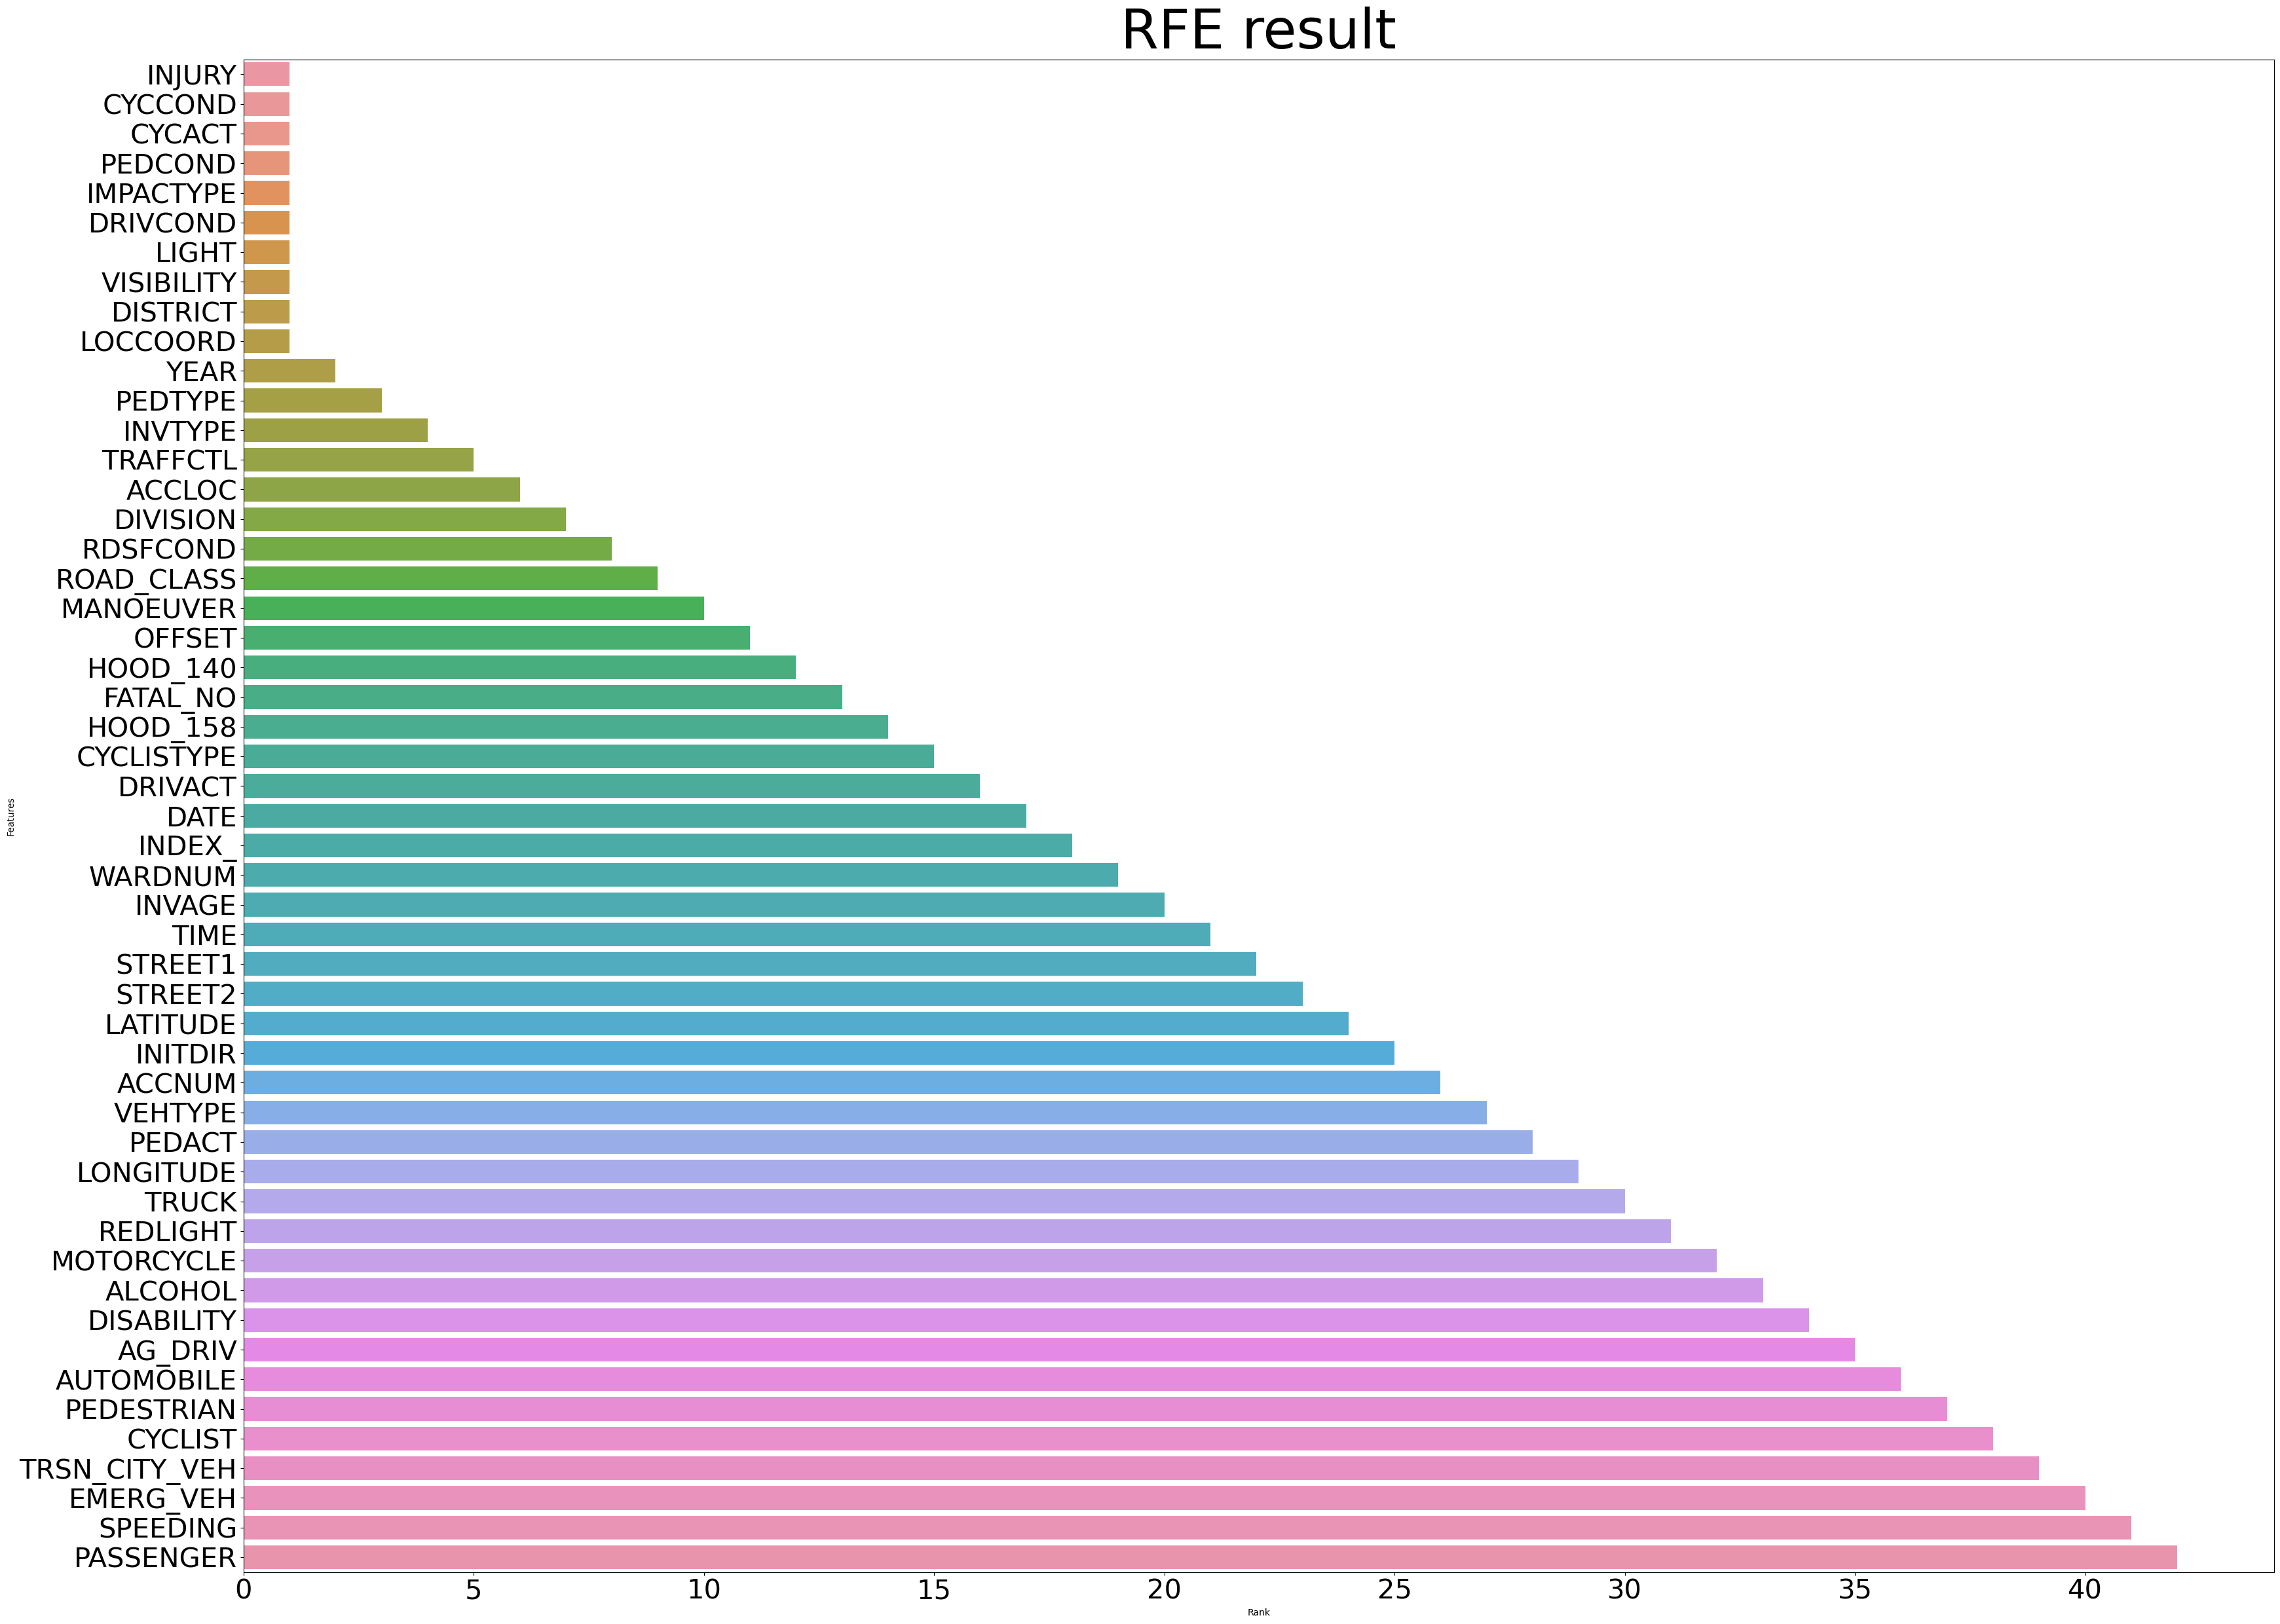

In [263]:
# Plot the result
plt.figure(figsize=(40, 30))
sns.barplot(x=ranking['Rank'], y=ranking.index)
plt.title('RFE result', fontsize=60)
plt.xlabel('Rank')
plt.ylabel('Features')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

In [264]:
# * We can see that 'NSA' is present in 'HOOD_158' and 'HOOD_140' columns. This value doesn't make sense, so we can drop it.
cols = ['HOOD_158', 'HOOD_140']
df[cols] = df[cols].replace("NSA", np.nan)
df = df.dropna(subset=['HOOD_158', 'HOOD_140'])

columns_to_drop = ['INJURY', 'YEAR', 'TIME', 'ROAD_CLASS', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'MANOEUVER',
                   'DRIVACT', 'DRIVCOND', 'INVAGE', 'TRUCK',  'MONTH', 'DAY', 'HOUR', 'MINUTES', 'DAY_OF_WEEK', 'PASSENGER', 'ALCOHOL', 'DISABILITY', 'INITDIR', 'LONGITUDE', 'LATITUDE']
# Drop 'INJURY' because its coefficient is low
# We also drop 'LONGITUDE' and 'LATITUDE' because according to the requirement, model will predict the severity of accident in certain neighbourhoods
df_official = df.drop(columns=columns_to_drop, axis=1)
df_official[cols] = df_official[cols].astype(np.number)

In [265]:
# Save cleaned data with SMOTE
df_official.to_csv('cleaned_data_KSI.csv', index=False)

# Import cleaned file
df_official = pd.read_csv('cleaned_data_KSI.csv')

# Print info of the data
df_official.info()

x_group3 = df_official.drop(columns=['ACCLASS'], axis=1)
y_group3 = df_official['ACCLASS']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VISIBILITY     17522 non-null  object 
 1   ACCLASS        17522 non-null  object 
 2   VEHTYPE        14350 non-null  object 
 3   PEDESTRIAN     17522 non-null  int64  
 4   CYCLIST        17522 non-null  int64  
 5   AUTOMOBILE     17522 non-null  int64  
 6   MOTORCYCLE     17522 non-null  int64  
 7   TRSN_CITY_VEH  17522 non-null  int64  
 8   EMERG_VEH      17522 non-null  int64  
 9   SPEEDING       17522 non-null  int64  
 10  AG_DRIV        17522 non-null  int64  
 11  REDLIGHT       17522 non-null  int64  
 12  HOOD_158       17522 non-null  float64
 13  HOOD_140       17522 non-null  float64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.9+ MB


In [266]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
for train_index, test_index in sss.split(x_group3, y_group3):
    x_train, x_test = x_group3.iloc[train_index], x_group3.iloc[test_index]
    y_train, y_test = y_group3.iloc[train_index], y_group3.iloc[test_index]


print("Before using SMOTE")
print(y_train.value_counts())

Before using SMOTE
Non-Fatal Injury    10564
Fatal                1701
Name: ACCLASS, dtype: int64


In [267]:
x_train, y_train = SMOTENC(random_state=5, categorical_features=[
                           0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).fit_resample(x_train, y_train)

#! Important note: SMOTE cannot handle more than 15 features
print("After using SMOTE")
print(y_train.value_counts())

After using SMOTE
Fatal               10564
Non-Fatal Injury    10564
Name: ACCLASS, dtype: int64


In [268]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, x_train.select_dtypes(include='number').columns),
    ('cat', cat_pipeline, x_train.select_dtypes(include='object').columns)
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Test the pipeline
x_train_prepared = full_pipeline.fit_transform(x_train)


log_reg = LogisticRegression(random_state=5)
log_reg.fit(x_train_prepared, y_train)

LogisticRegression(random_state=5)

In [269]:
y_pred = log_reg.predict(x_train_prepared)
print("Accuracy score on training data: ", accuracy_score(y_train, y_pred))

x_test_transformed = full_pipeline.transform(x_test)
y_pred = log_reg.predict(x_test_transformed)
print("Accuracy score on testing data: ", accuracy_score(y_test, y_pred))

Accuracy score on training data:  0.6298750473305567
Accuracy score on testing data:  0.6225984401750048
